In [2]:
# If you are not using Colab, you can skip the first 4 cells and make sure the dataset are in your working directory
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [11]:
## We download the datasets into Colab

id = '1xmdWz92zLVjrfHWPfD4T5sW58izUC34i'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('asset_details.csv')


In [ ]:
id2 = '1m53-zySL0nkNyii5gk91e2V0ucWra60o'
downloaded = drive.CreateFile({'id':id2}) 
downloaded.GetContentFile('supplemental_train.csv')

In [2]:
id3 = '1dFO-lIeLKBx4V3JqVOrx5L7ymSxH18Vl'
downloaded = drive.CreateFile({'id':id3}) 
downloaded.GetContentFile('train.csv')

In [3]:
id4 = '1gz1EzYSq1d1Ggox9Hel0DYK64YZVo1y0'
downloaded = drive.CreateFile({'id':id4}) 
downloaded.GetContentFile('Bitcoin_df.csv')

In [1]:
############################ After we mount the google drive files to the workspace ###
############################# Restart Colab runtime here and release memory############
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import gc

In [2]:
## Read in the asset_details data set
asset_info = pd.read_csv('asset_details.csv')
asset_info = asset_info.sort_values('Asset_ID',ascending=True).reset_index().iloc[:,1:]
Asset_ID = np.unique(asset_info['Asset_ID'])
asset_info

,Asset_ID,Weight,Asset_Name
0,0,4.304065,Binance Coin
1,1,6.779922,Bitcoin
2,2,2.397895,Bitcoin Cash
3,3,4.406719,Cardano
4,4,3.555348,Dogecoin
5,5,1.386294,EOS.IO
6,6,5.894403,Ethereum
7,7,2.079442,Ethereum Classic
8,8,1.098612,IOTA
9,9,2.397895,Litecoin


In [ ]:
## Read in the supplemental train set
suppl_train = pd.read_csv('supplemental_train.csv')

In [3]:
## Read in the train set
train = pd.read_csv('train.csv')

In [ ]:
print(train.shape)
print(suppl_train.shape)
print(train.tail())

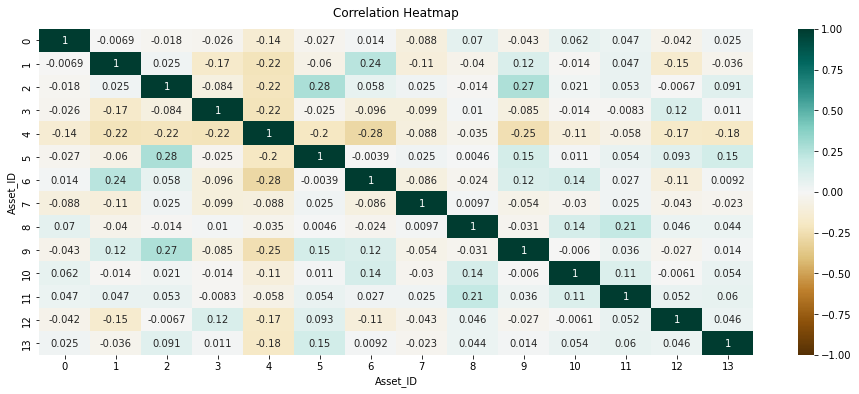

In [ ]:
## Examine the correlation of the target for each crypto
X = train.pivot(index='timestamp', columns='Asset_ID')['Target']
X = X.dropna(axis=0, how='any')
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(X.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
#del(X)

In [ ]:
fig, ax = plt.subplots(14,14,figsize=(72, 3.5*14))
for i in range(0,14):
    for j in range(i,14):
        if (i != j):
            asset_ij = 'rolling_corr_of_' + str(i) + '_and_' + str(j)
            ax[i][j].plot(X.loc[:,i].rolling(48*60).corr(X.loc[:,j]))
            ax[i][j].set_title(asset_ij)


In [ ]:
## Note the timestamp does not always move by 60 secs, and sometimes it moves forward by 8 mins without trading in between
time_index = np.unique(train['timestamp'])
diff = time_index[1:]-time_index[0:-1]
stats.describe(diff)
np.unique(diff)

array([ 60, 120, 180, 240, 300, 360, 480], dtype=int32)

In [ ]:
del(X)
del(fig)
del(ax)
del(time_index)
del(diff)
gc.collect()

322857

In [6]:
##### Define some utilities function

# A function to tabulate % of missing values in each of the column in a dataframe
def missing_val_table(dataframe):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    return missing_df

In [5]:
## Define a function to downcast the variables to save memory
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))

In [ ]:
reduce_mem_usage(suppl_train)
# Check the current data types
suppl_train.dtypes

Mem. usage decreased to 48.04 Mb (0.0% reduction)


timestamp      int32
Asset_ID        int8
Count        float32
Open         float16
High         float16
Low          float16
Close        float16
Volume       float32
VWAP         float16
Target       float16
dtype: object

In [7]:
reduce_mem_usage(train)
# Check the current data types
train.dtypes

Mem. usage decreased to 716.53 Mb (61.2% reduction)


timestamp      int32
Asset_ID        int8
Count        float32
Open         float16
High         float16
Low          float16
Close        float16
Volume       float32
VWAP         float64
Target       float16
dtype: object

In [ ]:
################################# Data Processing on a high level for all assets on the master train data set
## Create a column in the training dataset for the minute return of each asset

for a_id in Asset_ID:
    df_temp = train.loc[train["Asset_ID"]==a_id,:].reset_index().loc[:,['timestamp','Asset_ID','Close']]
    col = 'RET_' + str(a_id)
    df_temp[col] = df_temp['Close']/df_temp['Close'].shift(1) - 1
    train = pd.merge(train, df_temp.drop(columns=['Close']), on=['timestamp', 'Asset_ID'], how='left')
    del(df_temp)
    gc.collect()

train.iloc[:,10:] = train.iloc[:,10:].fillna(value=0)
train['RET'] = train.iloc[:, 10:].sum(axis=1)
train.drop(columns=train.columns[10:-1],inplace=True)

In [ ]:
##### Part of Feature engineering, we create a proxy of the market Index by computing the weighted average
## of mintue returns of all the available crypto-assets at all timestamps
## This step takes long and can last for several hours

Crypto_index = pd.DataFrame({'timestamp':np.unique(train['timestamp']), 'RET_M':np.zeros(len(np.unique(train['timestamp'])))})
#k = 0
for t in np.unique(train['timestamp']):
    X_t = train.loc[train['timestamp']==t,'Asset_ID']
    W_t = asset_info.loc[X_t,'Weight']
    del(X_t)
    gc.collect()
    W_t = W_t/sum(W_t)
    W_t = W_t.reset_index().loc[:,'Weight']
    RET_t = train.loc[train['timestamp']==t,'RET'].reset_index().loc[:,'RET']
    Crypto_index.loc[k,'RET_M'] = sum(W_t*RET_t)
    k += 1
    if (k%10000 == 0):
        print(k)
    del(W_t)
    del(RET_t)
    gc.collect()
#reduce_mem_usage(Crypto_index)

In [ ]:
reduce_mem_usage(Crypto_index)
print(Crypto_index.dtypes)
Crypto_index.to_csv("Index_RET.csv",index=False)

In [356]:
#missing_val_table(X)
#X.shape

,n_miss,ratio
Target,21014,1.12


In [14]:
########################################### Feature Engineering for each of the asset #############################
## Define some technical indicator functions that will be used in feature engineering

## RSI function
def RSI(Close, period=14):
    Chg = Close - Close.shift(1)
    Chg_pos = pd.Series(index=Chg.index, data=Chg[Chg>0])
    Chg_pos = Chg_pos.fillna(0)
    Chg_neg = pd.Series(index=Chg.index, data=-Chg[Chg<0])
    Chg_neg = Chg_neg.fillna(0)
    
    up_mean = []
    down_mean = []
    for i in range(period+1, len(Chg_pos)+1):
        up_mean.append(np.mean(Chg_pos.values[i-period:i]))
        down_mean.append(np.mean(Chg_neg.values[i-period:i]))
    
    rsi = []
    for i in range(len(up_mean)):
        if ( up_mean[i] + down_mean[i] ==0 ):
            rsi.append(50)
        else:
            rsi.append(100 * up_mean[i] / ( up_mean[i] + down_mean[i] ) )
    rsi_series = pd.Series(index = Close.index[period:], data = rsi)
    return rsi_series

In [15]:
### Utilize the timestamp to get time features
def add_time_features(df):
    # Feature engineering
    df = df.assign(ds=df.index.values.astype('datetime64[s]'))
    # Calendar features
    #df = df.assign(month = df['ds'].dt.month)
    df = df.assign(dayofweek = df['ds'].dt.dayofweek)
    #df = df.assign(hour = df['ds'].dt.hour)
    return df

In [11]:
def process_coin_data(X):
  ############################## Feature engineering on close price
  X['SMA_10MA'] = X['Close'].rolling(window=10).mean()
  X['SMA_20MA'] = X['Close'].rolling(window=20).mean()
  X['SMA_50MA'] = X['Close'].rolling(window=50).mean()
  X['SMA_200MA'] = X['Close'].rolling(window=200).mean()
  # 1-min Return
  X['RET'] = X['Close']/X['Close'].shift(1) - 1
  # Deviation from VWAP
  X['Dev_VWAP'] = (X['Close']/X['VWAP'] - 1)
  # ROC9 and ROC20 - Rate of Change
  X['ROC9'] = X['Close']/X['Close'].shift(9) - 1
  X['ROC20'] = X['Close']/X['Close'].shift(20) - 1

  ############################## Feature engineering on volume
  X['VMA_20MA'] = X['Volume'].rolling(window=20).mean()
  X['V_vs_V20MA'] = X['Volume']/X['VMA_20MA']

  ############################## Feature engineering for potential reversal signals
  # Deviation vs moving averages
  X['Dev_20MA'] = (X['Close']/X['SMA_20MA'] - 1)
  X['Dev_50MA'] = (X['Close']/X['SMA_50MA'] - 1)
  X['Dev_200MA'] = (X['Close']/X['SMA_200MA'] - 1)

  ############################## Feature engineering for potential trend-following signals
  # Ordering of Moving averages - We use two ordering checks
  X['MA_up_order1'] = [1 if X.loc[x,'SMA_10MA']>X.loc[x,'SMA_20MA'] else 0 for x in range(0,len(X['SMA_20MA']))]
  X['MA_up_order2'] = [1 if X.loc[x,'SMA_20MA']>X.loc[x,'SMA_50MA'] else 0 for x in range(0,len(X['SMA_20MA']))]
  X['MA_down_order1'] = [1 if X.loc[x,'SMA_10MA']<X.loc[x,'SMA_20MA'] else 0 for x in range(0,len(X['SMA_20MA']))]
  X['MA_down_order2'] = [1 if X.loc[x,'SMA_20MA']<X.loc[x,'SMA_50MA'] else 0 for x in range(0,len(X['SMA_20MA']))]

  # %Slope of mid-term moving average - We use two measures
  X['SMA_Slope1'] = (X['SMA_20MA']-X['SMA_20MA'].shift(1))/X['Close']
  X['SMA_Slope2'] = (X['SMA_20MA']-X['SMA_20MA'].shift(5))/X['Close']

  ################################ Feature Engineering for technical indicators
  # Compute RSI for the crypto
  X['RSI'] = RSI(X['Close'],14)

  # MACD Computation
  ewma = pd.Series.ewm
  X['EMA12'] = ewma(X["Close"], span=12).mean()
  X['EMA26'] = ewma(X["Close"], span=26).mean()
  X['MACD'] = X['EMA12']-X['EMA26']
  X['MACD_signal'] = ewma(X["MACD"], span=9).mean()
  X['MACD_h'] = X['MACD'] - X['MACD_signal']
  X.drop(columns=['EMA12','EMA26'],inplace = True)

  # Create indicators for MACD crossover
  X['MACD_crx_above'] = [1 if (X.loc[x,'MACD_h']>0 and X.loc[x-1,'MACD_h']<0) else 0 for x in range(0,len(X['SMA_20MA']))]
  X['MACD_crx_below'] = [1 if (X.loc[x,'MACD_h']<0 and X.loc[x-1,'MACD_h']>0) else 0 for x in range(0,len(X['SMA_20MA']))]

  ################################## Feature Engineering - Candle Stick Features
  X['Bar_size'] = (X['Close'] - X['Open'])/X['Close']

  ## Find upper shadow and down shadow in percentage terms
  up_shadow = []
  down_shadow = []
  for i in range(0,len(X['Close'])):
      up_shadow.append((X.loc[i,'High'] - max(X.loc[i,'Open'],X.loc[i,'Close']))/X.loc[i,'Close'])
      down_shadow.append((X.loc[i,'Low'] - min(X.loc[i,'Open'],X.loc[i,'Close']))/X.loc[i,'Close'])
  up_shadow = np.array(up_shadow)
  down_shadow = np.array(down_shadow)
  X['up_shadow'] = up_shadow
  X['down_shadow'] = down_shadow 
  del(up_shadow)
  del(down_shadow)

  ################## Add a feature to represent the relative strength of the crypto against the rest of market
  X['RS'] = X['RET'] - X['RET_M']
  X['RS_10MIN'] = X['RS'].rolling(window=10).sum()
  X['RS_20MIN'] = X['RS'].rolling(window=20).sum()
  X['RS_50MIN'] = X['RS'].rolling(window=50).sum()
  X['RS_200MIN'] = X['RS'].rolling(window=200).sum()

  ########################################################### Add volatility features 
  X['Vol_20min'] = X['RET'].rolling(window=20).std()
  X['Vol_50min'] = X['RET'].rolling(window=50).std()
  X['Vol_200min'] = X['RET'].rolling(window=200).std()
  X['Vol_SLT_ratio'] = X['Vol_20min']/X['Vol_200min'] 

  X['Vol_ST_below_LT'] = [1 if (X.loc[x,'Vol_SLT_ratio']<1) else 0 for x in range(0,len(X['Vol_SLT_ratio']))]
  X['pct_vol_compr_20min'] = X['Vol_ST_below_LT'].rolling(window=20).sum()/20
  X['pct_vol_compr_50min'] = X['Vol_ST_below_LT'].rolling(window=50).sum()/50
  X['pct_vol_compr_200min'] = X['Vol_ST_below_LT'].rolling(window=200).sum()/200

  ### Add features to check breakout - Rolling max and min
  X['High_20min'] = X['High'].rolling(window=20).max()
  X['High_50min'] = X['High'].rolling(window=50).max()
  X['High_200min'] = X['High'].rolling(window=200).max()
  X['Dev_to_High20m'] = X['Close']/X['High_20min']
  X['Dev_to_High50m'] = X['Close']/X['High_50min']
  X['Dev_to_High200m'] = X['Close']/X['High_200min']

  X['Low_20min'] = X['Low'].rolling(window=20).min()
  X['Low_50min'] = X['Low'].rolling(window=50).min()
  X['Low_200min'] = X['Low'].rolling(window=200).min()
  X['Dev_to_Low20m'] = X['Close']/X['Low_20min']
  X['Dev_to_Low50m'] = X['Close']/X['Low_50min']
  X['Dev_to_Low200m'] = X['Close']/X['Low_200min']



In [12]:
################################### Select the asset ID that you want build models from here ####################################
############################## Due to the lengthy training time and only limited number of assets to loop through, we can do
## them one by one, and check the results individually

### We change the asset id, train the model and save the results

id_chosen = 1
X = train.loc[train['Asset_ID']==id_chosen,:].reset_index().iloc[:,1:]
Crypto_index = pd.read_csv("Index_RET.csv")
Crypto_index.head()
X = X.merge(Crypto_index,how='left',on='timestamp')
X.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,RET_M
0,1514764860,1,229.0,13832.0,14016.0,13664.0,13848.0,31.550062,13827.062093,-0.014641,0.000000
1,1514764920,1,235.0,13832.0,14056.0,13680.0,13832.0,31.046432,13840.362591,-0.015038,-0.001523
2,1514764980,1,528.0,13824.0,14000.0,13600.0,13800.0,55.061821,13806.068014,-0.010307,-0.000765
3,1514765040,1,435.0,13800.0,14000.0,13576.0,13768.0,38.780529,13783.598101,-0.009003,-0.002277
4,1514765100,1,742.0,13768.0,13952.0,13552.0,13728.0,108.501640,13735.586842,-0.008080,-0.004475


In [16]:
process_coin_data(X) ## 12 minutes needed in Colab

In [17]:
reduce_mem_usage(X)
gc.collect()

Mem. usage decreased to 310.77 Mb (64.5% reduction)


8

In [18]:
####### Add time features 
X = X.set_index("timestamp")
X = add_time_features(X)

#X = X.join(pd.get_dummies(X['hour'], prefix='hour'))
X = X.join(pd.get_dummies(X['dayofweek'],prefix='weekday'))
#X.drop(columns=['dayofweek','hour','ds'],inplace=True)
X.drop(columns=['dayofweek','ds'],inplace=True)

In [19]:
X = X.reset_index()
X.head()


,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,...,Dev_to_Low20m,Dev_to_Low50m,Dev_to_Low200m,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,1514764860,1,229.0,13832.0,14016.0,13664.0,13848.0,31.546875,13824.0,-0.014641,...,NaN,NaN,NaN,1,0,0,0,0,0,0
1,1514764920,1,235.0,13832.0,14056.0,13680.0,13832.0,31.046875,13840.0,-0.015038,...,NaN,NaN,NaN,1,0,0,0,0,0,0
2,1514764980,1,528.0,13824.0,14000.0,13600.0,13800.0,55.062500,13808.0,-0.010307,...,NaN,NaN,NaN,1,0,0,0,0,0,0
3,1514765040,1,435.0,13800.0,14000.0,13576.0,13768.0,38.781250,13784.0,-0.009003,...,NaN,NaN,NaN,1,0,0,0,0,0,0
4,1514765100,1,742.0,13768.0,13952.0,13552.0,13728.0,108.500000,13736.0,-0.008080,...,NaN,NaN,NaN,1,0,0,0,0,0,0


In [20]:
filename_data = 'asset_id_' + str(id_chosen) + '.csv'
X.to_csv(filename_data,index=False)
X.tail()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,...,Dev_to_Low20m,Dev_to_Low50m,Dev_to_Low200m,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
1956277,1632182160,1,1940.0,42976.0,43008.0,42880.0,42912.0,56.84375,42944.0,NaN,...,1.007812,1.008789,1.008789,1,0,0,0,0,0,0
1956278,1632182220,1,2026.0,42912.0,42944.0,42848.0,42848.0,81.00000,42880.0,NaN,...,1.005859,1.007812,1.007812,1,0,0,0,0,0,0
1956279,1632182280,1,1986.0,42848.0,42880.0,42784.0,42816.0,65.68750,42848.0,NaN,...,1.004883,1.006836,1.006836,1,0,0,0,0,0,0
1956280,1632182340,1,4047.0,42848.0,43040.0,42816.0,43008.0,138.37500,42944.0,NaN,...,1.009766,1.011719,1.011719,1,0,0,0,0,0,0
1956281,1632182400,1,2698.0,43008.0,43040.0,42976.0,43008.0,128.25000,43008.0,NaN,...,1.008789,1.011719,1.011719,0,1,0,0,0,0,0


In [ ]:
### Note that not all crypto exist in all the time periods
grouped_df = train.iloc[:,0:2].groupby("timestamp")
grouped_df = grouped_df.agg({"Asset_ID": "nunique"})
grouped_df = grouped_df.reset_index()
print(grouped_df)
#del(grouped_df)
gc.collect()

          timestamp  Asset_ID
0        1514764860         8
1        1514764920         8
2        1514764980         8
3        1514765040         8
4        1514765100         8
...             ...       ...
1956777  1632182160        14
1956778  1632182220        14
1956779  1632182280        14
1956780  1632182340        14
1956781  1632182400        14

[1956782 rows x 2 columns]


21

In [ ]:
reduce_mem_usage(X)

Mem. usage decreased to 139.92 Mb (76.0% reduction)


In [144]:
np.isnan(X.loc[:,'Target'])

timestamp
1514764860    False
1514764920    False
1514764980    False
1514765040    False
1514765100    False
              ...  
1632182160     True
1632182220     True
1632182280     True
1632182340     True
1632182400     True
Name: Target, Length: 1956282, dtype: bool

We will do recursive training for every 3 months, using 2 month for model fitting and 1 month for validation. Then we will use the model to predict the target variable in the coming 3 months. 


In [3]:
################################ Train the LGBT model for the asset chosen


############################ LGBT #######################
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

In [61]:
#filename_data = 'asset_id_' + str(0) + '.csv'
#X = pd.read_csv(filename_data)

In [59]:
#id_chosen = 13

In [62]:
time_forward = 60*24*30*3 ## The number of minutes in a quarter's time
fraction_train = 2/3      ## The fraction of data used for training in the quarter
num_train = X.shape[0]//time_forward   ## number of training samples
train_start = 0
asset_ID = X['Asset_ID'][0]
non_predictor = ['Asset_ID','Target','timestamp']
train_corr = []
test_corr = []
parameters = {'max_depth':[5,6,7,8,9,10,11,12], 'learning_rate':[0.02,0.05,0.1,0.2], 'reg_lambda':[0.1,1,10,100,1000]}

if (id_chosen == 10):
    time_forward = 60*24*30  # If Maker is chosen, change to monthly model fitting
    train_start = 129600

# Create a data frame to store the feature importance
imp_df = pd.DataFrame()
train_features = [f for f in X.columns if f not in non_predictor]
imp_df["feature"] = list(train_features)
imp_df["importance"] = np.zeros(len(train_features))

for i in range(0,num_train):
    ## Locate the index for the split in training, validation and testing
    train_end = train_start + int(time_forward*2/3)
    valid_start = train_start + int(time_forward*2/3) + 1
    valid_end = train_start + time_forward
    test_start = valid_end + 1
    test_end = min(valid_end + time_forward, X.shape[0])
    
    if (valid_end +1 < X.shape[0]):
        
        print([train_start,train_end,valid_start,valid_end,test_start,test_end])

        ## Subset the data from X for training and hyperparameter tuning
        df = X.iloc[train_start:valid_end,:].reset_index(drop=True)
        df.dropna(subset=['Target'],inplace=True)
        df_train_X = df.drop(columns=non_predictor)
        df_train_Y = df['Target'].values
        del(df)
        gc.collect()

        # Data Normalization
        scaler = MinMaxScaler(feature_range = (0, 1))
        df_train_X = scaler.fit_transform(df_train_X)

        # Specify the model and grid search for the best set of hyperparameters
        ## Hyper-parameter Tuning for the quarterly model
        model = lgbm.LGBMRegressor(boosting_type='gbdt', objective='regression', n_estimators=100,
                                    metric='rmse')

        split_index = np.repeat(0, len(df_train_Y))
        split_index[0:int(df_train_Y.shape[0]*fraction_train)]=-1
        split_index
        ps = PredefinedSplit(test_fold= split_index)
        clf = GridSearchCV(model, cv = ps, param_grid=parameters)
        clf
        clf.fit(df_train_X, df_train_Y)

        ## Extract the best-fit model to do prediction and testing
        model_best = lgbm.LGBMRegressor(boosting_type='gbdt', objective='regression', n_estimators=100, 
                                    metric='rmse',**clf.best_params_)
        model_best.fit(df_train_X, df_train_Y)
        train_pred = model_best.predict(df_train_X)
        corr_t = np.corrcoef(df_train_Y, train_pred)[0,1]
        train_corr.append(corr_t)
        print('Training Correlation : {}'.format(corr_t))
        imp_df["importance"] += model_best.feature_importances_

        del(df_train_X)
        del(df_train_Y)
        del(clf)
        del(ps)
        del(split_index)
        gc.collect()

        # testing
        df = X.iloc[test_start:test_end,:].reset_index(drop=True)
        df.dropna(subset=['Target'],inplace=True)
        df_test_X = df.drop(columns=non_predictor)
        df_test_Y = df['Target'].values
        del(df)
        gc.collect()
        df_test_X = scaler.transform(df_test_X)
        test_pred = model_best.predict(df_test_X)
        #R2_test = r2_score(df_valid_Y, valid_pred)
        #print('Validation R^2 : {}'.format(R2_valid))
        corr_test_t = np.corrcoef(df_test_Y, test_pred)[0,1]
        test_corr.append(corr_test_t)
        print('Testing Correlation : {}'.format(corr_test_t))

        train_start += time_forward
    
# Save the corr over different time    
corr_df = pd.DataFrame()
corr_df['train_corr'] = train_corr
corr_df['test_corr'] = test_corr
corr_df
filename = 'Asset_id' + str(asset_ID) + '_corr_quarterly.csv'
corr_df.to_csv(filename,index=False)

# Save the feature importance
filename = 'Asset_id' + str(asset_ID) + '_feat_imp.csv'
imp_df.to_csv(filename,index=False)

[0, 86400, 86401, 129600, 129601, 259200]
Training Correlation : 0.39408721758870263
Testing Correlation : 0.025960932818238042
[129600, 216000, 216001, 259200, 259201, 388800]
Training Correlation : 0.27452336600157695
Testing Correlation : 0.016439458282239527
[259200, 345600, 345601, 388800, 388801, 518400]
Training Correlation : 0.31399010856101484
Testing Correlation : 0.004506947916279373
[388800, 475200, 475201, 518400, 518401, 648000]
Training Correlation : 0.31150258652780627
Testing Correlation : 0.003127014294596685
[518400, 604800, 604801, 648000, 648001, 777600]
Training Correlation : 0.27203380672431127
Testing Correlation : 0.057620925594002705
[648000, 734400, 734401, 777600, 777601, 907200]
Training Correlation : 0.34819483059077183
Testing Correlation : 0.02812455144802592
[777600, 864000, 864001, 907200, 907201, 1036800]
Training Correlation : 0.4570525918861728
Testing Correlation : 0.026076884245025904
[907200, 993600, 993601, 1036800, 1036801, 1166400]
Training Co

In [354]:
X.shape

(1874560, 11)

<BarContainer object of 68 artists>

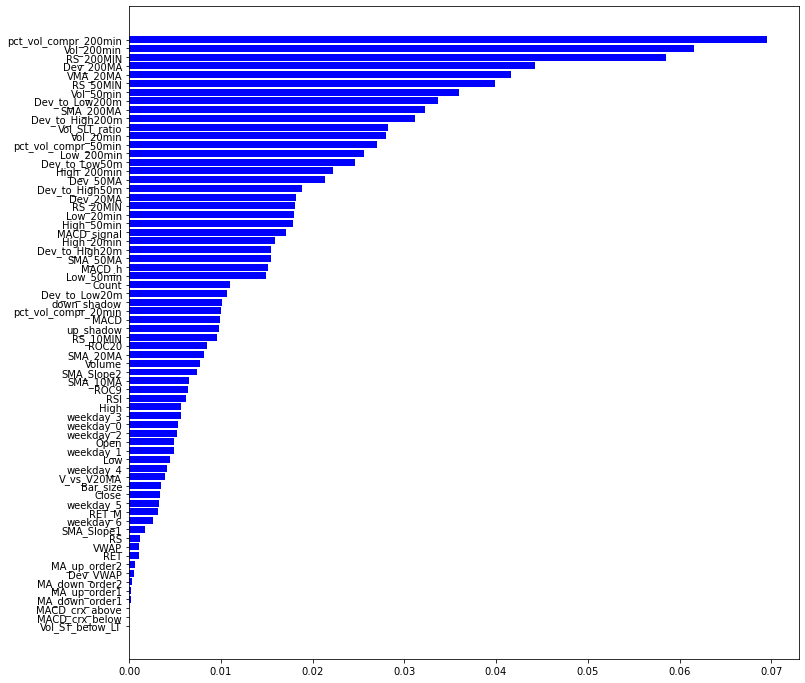

In [23]:
imp_df["importance"] = imp_df["importance"]/sum(imp_df["importance"])
imp_df.sort_values(by='importance',ascending=True, inplace=True)

'''
feat_imp2 = imp_df.sort_values(by='importance',ascending=False)
feat_to_plot = feat_imp2[0:35].sort_values(by='importance',ascending=True)

# Plot the top 30 feature importance
plt.figure(figsize = (12, 12))
ax = plt.subplot()
ax.barh(list(feat_to_plot.feature),
    feat_to_plot.importance, 
    align = 'center', color = 'blue')
'''

plt.figure(figsize = (12, 12))
ax = plt.subplot()
ax.barh(list(imp_df.feature),
    imp_df.importance, 
    align = 'center', color = 'blue')

In [104]:
train_corr

[0.4691193812050074, 0.292908646448905]

In [124]:
time_forward = 60*24*30
fraction_train = 2/3
num_train = X.shape[0]//time_forward
num_train

45

In [365]:
print(np.mean(train_corr))
np.mean(test_corr)

0.35770900615089335


0.032967227388632156

## Performance Evauluation of GBT Models


In [33]:
asset_info['Avg_Corr'] = np.zeros(asset_info.shape[0])
asset_info['Max_Corr'] = np.zeros(asset_info.shape[0])
asset_info['Min_Corr'] = np.zeros(asset_info.shape[0])

special_id = 10
for id in asset_info['Asset_ID']:
    # We read in the csv files in our previous training and testing loops
    if id == special_id:
        filename = 'Asset_id' + str(id) + '_corr_monthly.csv'
    else:
        filename = 'Asset_id' + str(id) + '_corr_quarterly.csv'
    corr_df = pd.read_csv(filename)
    asset_info.loc[id,'Avg_Corr'] = np.mean(corr_df['test_corr'])
    asset_info.loc[id,'Max_Corr'] = np.max(corr_df['test_corr'])
    asset_info.loc[id,'Min_Corr'] = np.min(corr_df['test_corr'])

print(asset_info)
asset_info.to_csv("GBT.csv",index=False)
print(' ')
print('The weighted Pearson correlation coefficient:')
print(round(sum(asset_info['Weight']*asset_info['Avg_Corr'])/sum(asset_info['Weight']),6))

    Asset_ID    Weight        Asset_Name  Avg_Corr  Max_Corr  Min_Corr
0          0  4.304065      Binance Coin  0.018159  0.056588 -0.014473
1          1  6.779922           Bitcoin  0.041549  0.105900 -0.015726
2          2  2.397895      Bitcoin Cash  0.037734  0.120114 -0.007438
3          3  4.406719           Cardano  0.025940  0.054882 -0.001347
4          4  3.555348          Dogecoin  0.029761  0.112303 -0.043611
5          5  1.386294            EOS.IO  0.038033  0.099625 -0.004546
6          6  5.894403          Ethereum  0.038807  0.103466  0.003143
7          7  2.079442  Ethereum Classic  0.036190  0.088624 -0.006312
8          8  1.098612              IOTA  0.027557  0.054453  0.006439
9          9  2.397895          Litecoin  0.041857  0.107342 -0.048068
10        10  1.098612             Maker  0.023865  0.050588 -0.004285
11        11  1.609438            Monero  0.034175  0.101786 -0.028338
12        12  2.079442           Stellar  0.042393  0.081303  0.002656
13    

<BarContainer object of 68 artists>

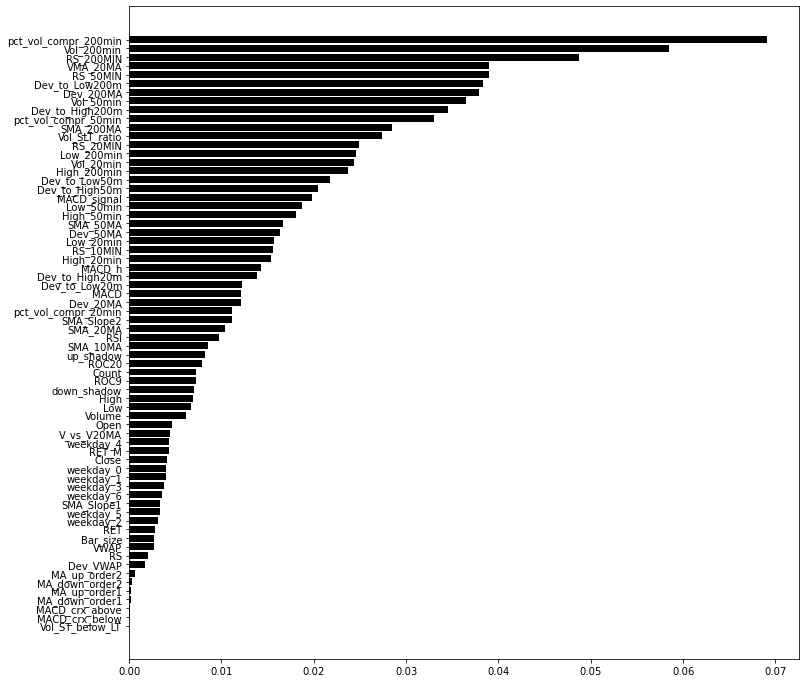

In [63]:
### Aggregate the feature importance for models of each crypto-asset

for id in asset_info['Asset_ID']:
    filename = 'Asset_id' + str(id) + '_feat_imp.csv'
    feat_imp_df = pd.read_csv(filename)
    if id == 1:
        cum_feat_imp = feat_imp_df
    cum_feat_imp.loc[:,'importance'] += feat_imp_df.loc[:,'importance']
    
cum_feat_imp["importance"] = cum_feat_imp["importance"]/sum(cum_feat_imp["importance"])
cum_feat_imp.sort_values(by='importance',ascending=True, inplace=True)
plt.figure(figsize = (12, 12))
ax = plt.subplot()
ax.barh(list(cum_feat_imp.feature),
    cum_feat_imp.importance, 
    align = 'center', color = 'black')